In [200]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D

import sys, os
sys.path.append(os.path.abspath(".."))

from preprocessing.preprocessing_utils import clean_data, feature_selection, scale_features

In [201]:
# Load training data
data = pd.read_csv('../data/claims_train.csv')

In [202]:
data=clean_data(data)

data["Claim_rate"]=(data["ClaimNb"]/data["Exposure"]).astype(float)

#data=feature_selection(data) # drops both idpol and density

numeric_cols = ["VehPower","VehAge","DrivAge","BonusMalus", "Density"]
categorical_cols = ["VehBrand","VehGas", "Area", "Region"]

data, scaler=scale_features(data, numeric_cols)

data_encoded= pd.get_dummies(data, columns=categorical_cols, drop_first=True)
original_data_wd=data_encoded.copy()
data_encoded = data_encoded.drop(columns=["ClaimNb", "Exposure", "Claim_rate", "IDpol"])

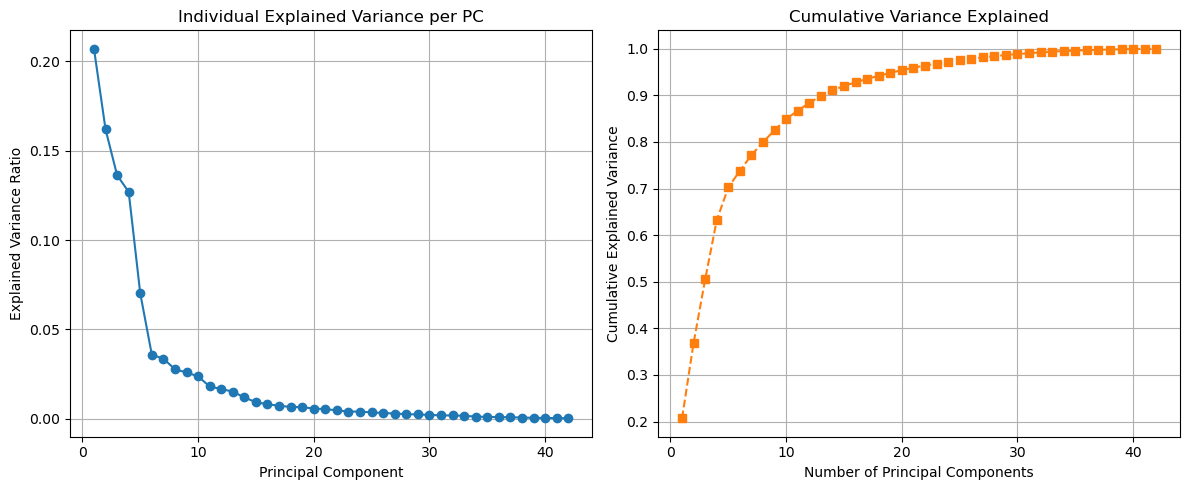

PC1: 0.207 variance, 0.207 cumulative
PC2: 0.162 variance, 0.369 cumulative
PC3: 0.136 variance, 0.505 cumulative
PC4: 0.127 variance, 0.632 cumulative
PC5: 0.070 variance, 0.702 cumulative
PC6: 0.036 variance, 0.738 cumulative
PC7: 0.034 variance, 0.772 cumulative
PC8: 0.028 variance, 0.800 cumulative
PC9: 0.026 variance, 0.825 cumulative
PC10: 0.024 variance, 0.849 cumulative
PC11: 0.018 variance, 0.867 cumulative
PC12: 0.017 variance, 0.884 cumulative
PC13: 0.015 variance, 0.899 cumulative
PC14: 0.012 variance, 0.911 cumulative
PC15: 0.009 variance, 0.920 cumulative
PC16: 0.008 variance, 0.928 cumulative
PC17: 0.007 variance, 0.935 cumulative
PC18: 0.007 variance, 0.942 cumulative
PC19: 0.006 variance, 0.948 cumulative
PC20: 0.006 variance, 0.954 cumulative
PC21: 0.005 variance, 0.959 cumulative
PC22: 0.005 variance, 0.964 cumulative
PC23: 0.004 variance, 0.968 cumulative
PC24: 0.004 variance, 0.972 cumulative
PC25: 0.004 variance, 0.976 cumulative
PC26: 0.003 variance, 0.979 cumula

In [203]:
pca_full = PCA().fit(data_encoded)
explained = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained)
pcs = np.arange(1, len(explained) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Individual explained variance
axes[0].plot(pcs, explained, marker='o', color='tab:blue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Individual Explained Variance per PC')
axes[0].grid(True)

# Cumulative explained variance
axes[1].plot(pcs, cumulative, marker='s', linestyle='--', color='tab:orange')
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print numeric summary
for i, (var, cum) in enumerate(zip(explained, cumulative)):
    print(f"PC{i+1}: {var:.3f} variance, {cum:.3f} cumulative")

choose pc between 2 and 4 to see best silhouette score compared to variance explained.

In [204]:
for n in [2, 3, 4]:
    print()
    X_pca = PCA(n_components=n, random_state=42).fit_transform(data_encoded)
    rng = np.random.default_rng(42)
    idx = rng.choice(len(X_pca), size=5000, replace=False)
    var = PCA(n_components=n).fit(data_encoded).explained_variance_ratio_.sum()

    print(f"\n--- {n} PCs --- variance={var:.2f} ---- ")
    for k in [2, 3, 4, 5, 6]:
        labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X_pca)
        score = silhouette_score(X_pca[idx], labels[idx])
        print(f"k={k}: silhouette={score:.3f}")



--- 2 PCs --- variance=0.37 ---- 
k=2: silhouette=0.428
k=3: silhouette=0.441
k=4: silhouette=0.353
k=5: silhouette=0.346
k=6: silhouette=0.326


--- 3 PCs --- variance=0.51 ---- 
k=2: silhouette=0.323
k=3: silhouette=0.328
k=4: silhouette=0.312
k=5: silhouette=0.279
k=6: silhouette=0.271


--- 4 PCs --- variance=0.63 ---- 
k=2: silhouette=0.277
k=3: silhouette=0.285
k=4: silhouette=0.251
k=5: silhouette=0.271
k=6: silhouette=0.249


k=2: silhouette=0.323
k=3: silhouette=0.328
k=4: silhouette=0.312
k=5: silhouette=0.279
k=6: silhouette=0.271
k=7: silhouette=0.252
k=8: silhouette=0.244
k=9: silhouette=0.247


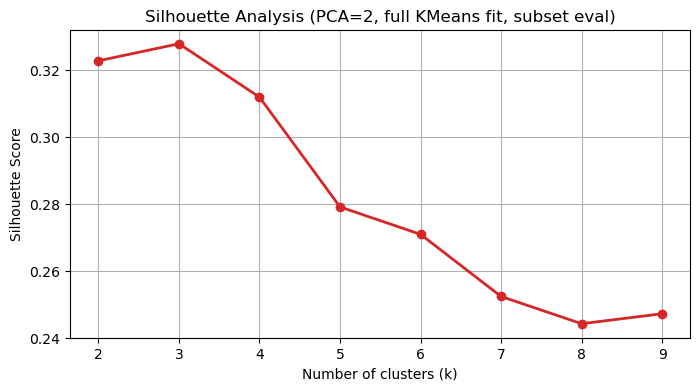

👉 Best k by silhouette score: 3


In [205]:
# --- PCA: fit once (2 components) ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(data_encoded)

# --- Use smaller subset for silhouette evaluation only ---
rng = np.random.default_rng(42)
idx = rng.choice(len(X_pca), size=min(5000, len(X_pca)), replace=False)

# --- Test multiple k values (on full data, same seed) ---
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_pca)  # fit on full PCA data
    sil = silhouette_score(X_pca[idx], labels[idx])  # evaluate on subset
    silhouette_scores.append(sil)
    print(f"k={k}: silhouette={sil:.3f}")

# --- Plot silhouette scores ---
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, 'o-', color='tab:red', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis (PCA=2, full KMeans fit, subset eval)')
plt.grid(True)
plt.show()

# --- Print best k ---
best_k = K[np.argmax(silhouette_scores)]
print(f"👉 Best k by silhouette score: {best_k}")


In [218]:
# Apply PCA with 3 components
pca = PCA(n_components=4)
pca_data = pca.fit_transform(data_encoded)

print('Explained variance ratio:', np.round(pca.explained_variance_ratio_, 3))

Explained variance ratio: [0.207 0.162 0.136 0.127]


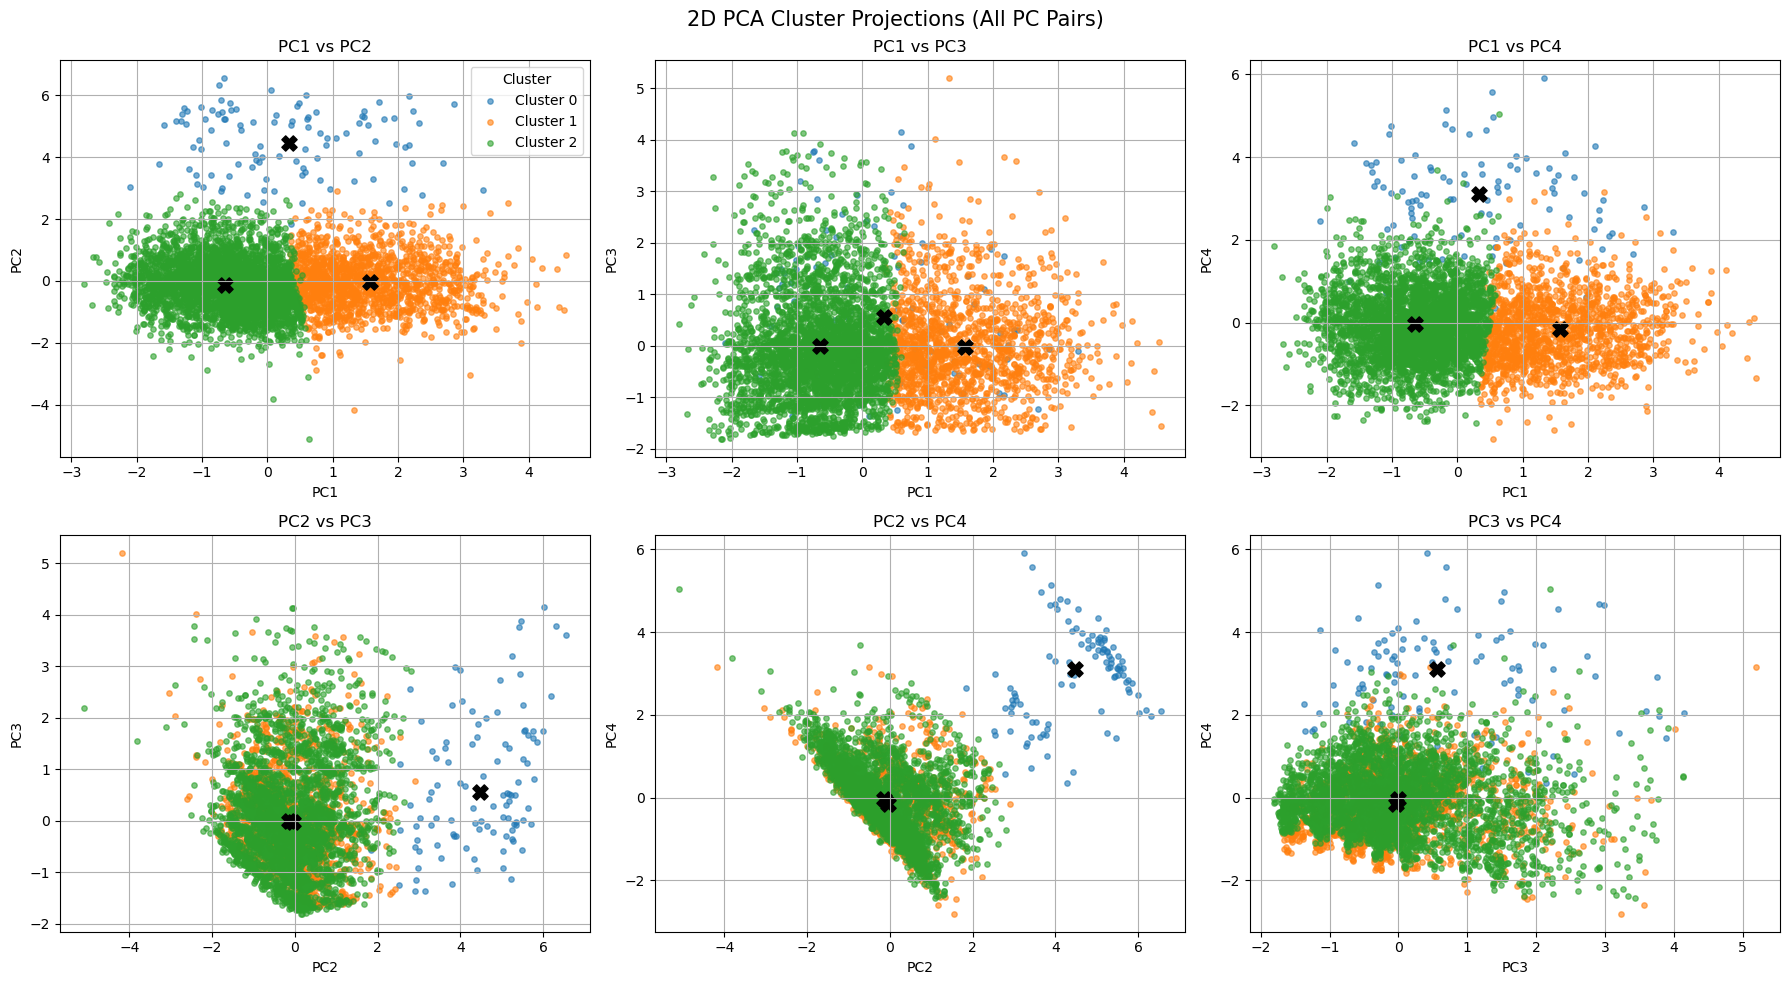

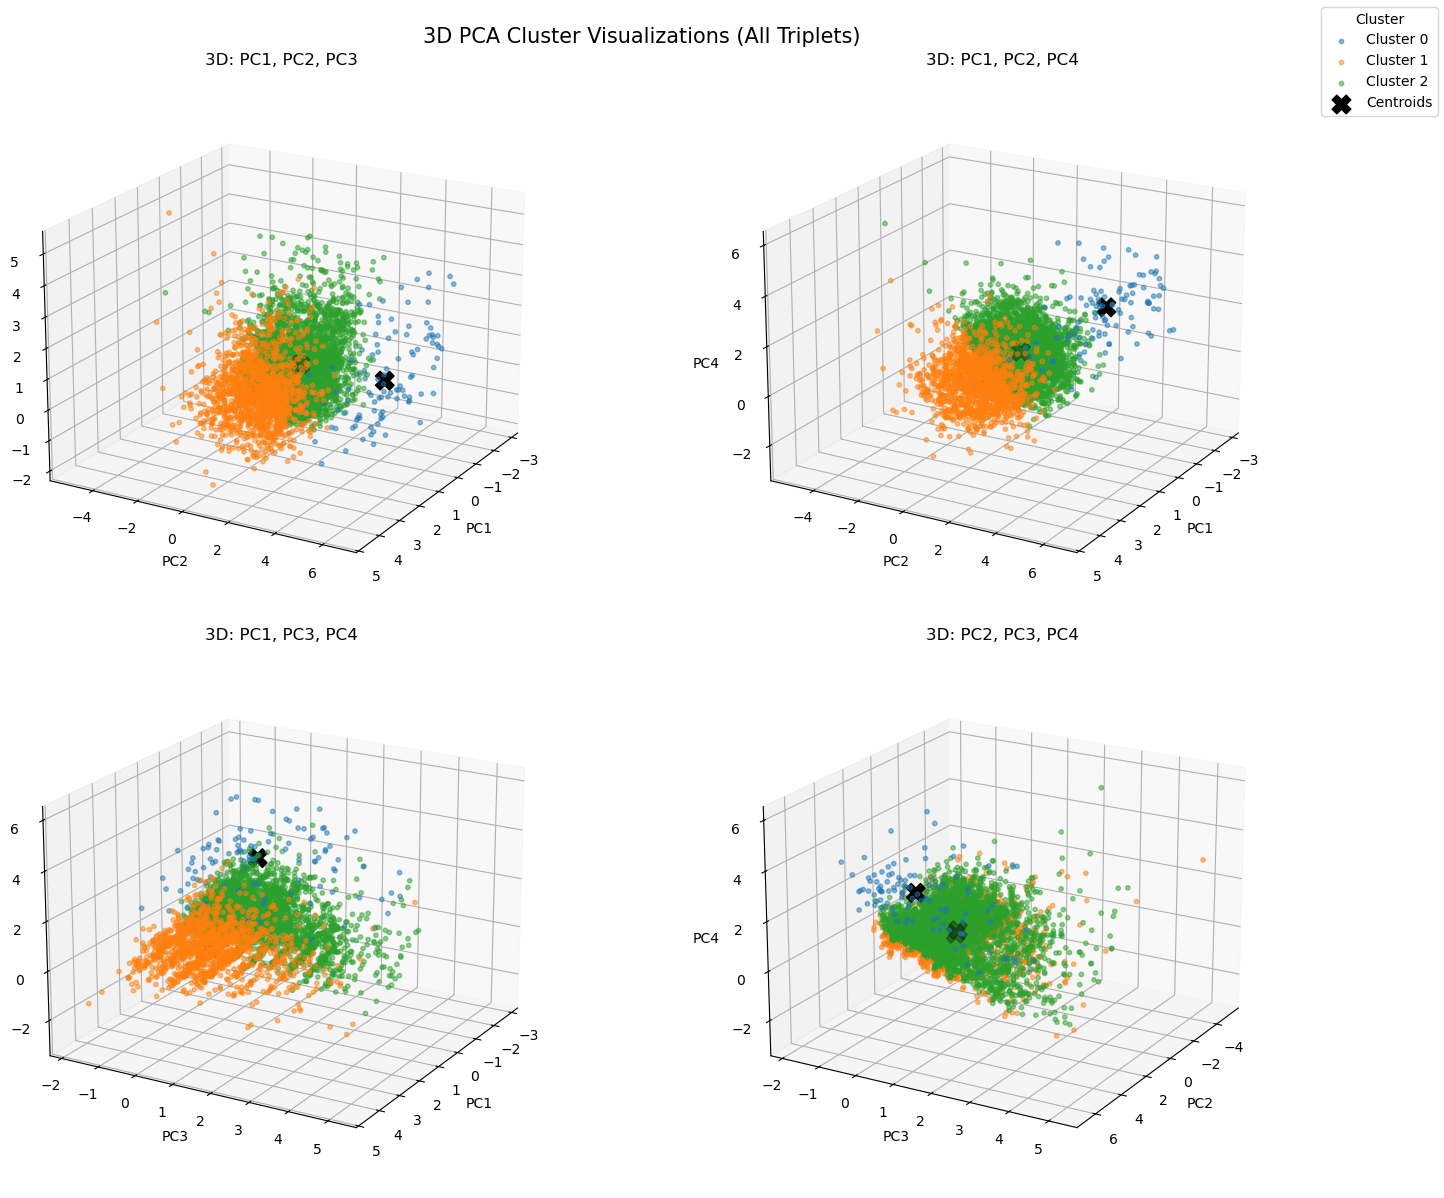

In [228]:

# 1️⃣ PCA + KMeans already fitted earlier
# ========================================
# (Assume you already have: pca_df, X_pca, labels, kmeans, centroids)
# Otherwise, fit them before running this cell

rng = np.random.default_rng(42)
plot_sample_idx = rng.choice(len(X_pca), size=min(5000, len(X_pca)), replace=False)
pca_sample = X_pca[plot_sample_idx]
cluster_sample = labels[plot_sample_idx]
centroids = kmeans.cluster_centers_

pcs_to_plot = [0, 1, 2, 3]  # PC1–PC4
colors = plt.cm.tab10.colors

# ========================================
# 2️⃣ 2D PCA Projections (all pairs)
# ========================================
pairs = list(itertools.combinations(pcs_to_plot, 2))
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for ax, (x_idx, y_idx) in zip(axes, pairs):
    for cluster_id in sorted(np.unique(cluster_sample)):
        subset = pca_sample[cluster_sample == cluster_id]
        ax.scatter(
            subset[:, x_idx],
            subset[:, y_idx],
            s=15,
            alpha=0.6,
            color=colors[cluster_id % len(colors)],
            label=f"Cluster {cluster_id}" if x_idx == 0 and y_idx == 1 else None
        )
    # Centroids
    ax.scatter(
        centroids[:, x_idx],
        centroids[:, y_idx],
        c="black",
        s=120,
        marker="X"
    )
    ax.set_xlabel(f"PC{x_idx+1}")
    ax.set_ylabel(f"PC{y_idx+1}")
    ax.set_title(f"PC{x_idx+1} vs PC{y_idx+1}")
    ax.grid(True)

axes[0].legend(title="Cluster")
plt.suptitle("2D PCA Cluster Projections (All PC Pairs)", fontsize=15)
plt.tight_layout()
plt.show()

# ========================================
# 3️⃣ 3D PCA Projections (all triplets)
# ========================================
triplets = list(itertools.combinations(pcs_to_plot, 3))
n_cols = 2
n_rows = int(np.ceil(len(triplets) / n_cols))

fig = plt.figure(figsize=(16, n_rows * 6))

for i, (x_idx, y_idx, z_idx) in enumerate(triplets, 1):
    ax = fig.add_subplot(n_rows, n_cols, i, projection="3d")
    for cluster_id in sorted(np.unique(cluster_sample)):
        subset = pca_sample[cluster_sample == cluster_id]
        ax.scatter(
            subset[:, x_idx],
            subset[:, y_idx],
            subset[:, z_idx],
            s=10,
            alpha=0.5,
            color=colors[cluster_id % len(colors)],
            label=f"Cluster {cluster_id}" if i == 1 else None
        )
    ax.scatter(
        centroids[:, x_idx],
        centroids[:, y_idx],
        centroids[:, z_idx],
        c="black",
        s=180,
        marker="X",
        label="Centroids" if i == 1 else None
    )
    ax.set_xlabel(f"PC{x_idx+1}")
    ax.set_ylabel(f"PC{y_idx+1}")
    ax.set_zlabel(f"PC{z_idx+1}")
    ax.set_title(f"3D: PC{x_idx+1}, PC{y_idx+1}, PC{z_idx+1}")
    ax.view_init(elev=20, azim=30)

fig.legend(title="Cluster", loc="upper right")
plt.suptitle("3D PCA Cluster Visualizations (All Triplets)", fontsize=15)
plt.tight_layout()
plt.show()



Top 5 features influencing PC1:
BonusMalus    0.690333
DrivAge       0.674431
VehAge        0.193700
VehPower      0.141809
Density       0.072999
Name: PC1, dtype: float64

Top 5 features influencing PC2:
Density         0.715295
VehAge          0.583383
VehPower        0.220579
VehBrand_B12    0.174313
Region_R24      0.123907
Name: PC2, dtype: float64

Top 5 features influencing PC3:
VehPower        0.890206
VehAge          0.437352
Density         0.088785
DrivAge         0.051353
VehBrand_B12    0.047602
Name: PC3, dtype: float64

Top 5 features influencing PC4:
Density           0.619060
VehAge            0.598188
VehPower          0.350036
DrivAge           0.265567
VehGas_Regular    0.129176
Name: PC4, dtype: float64


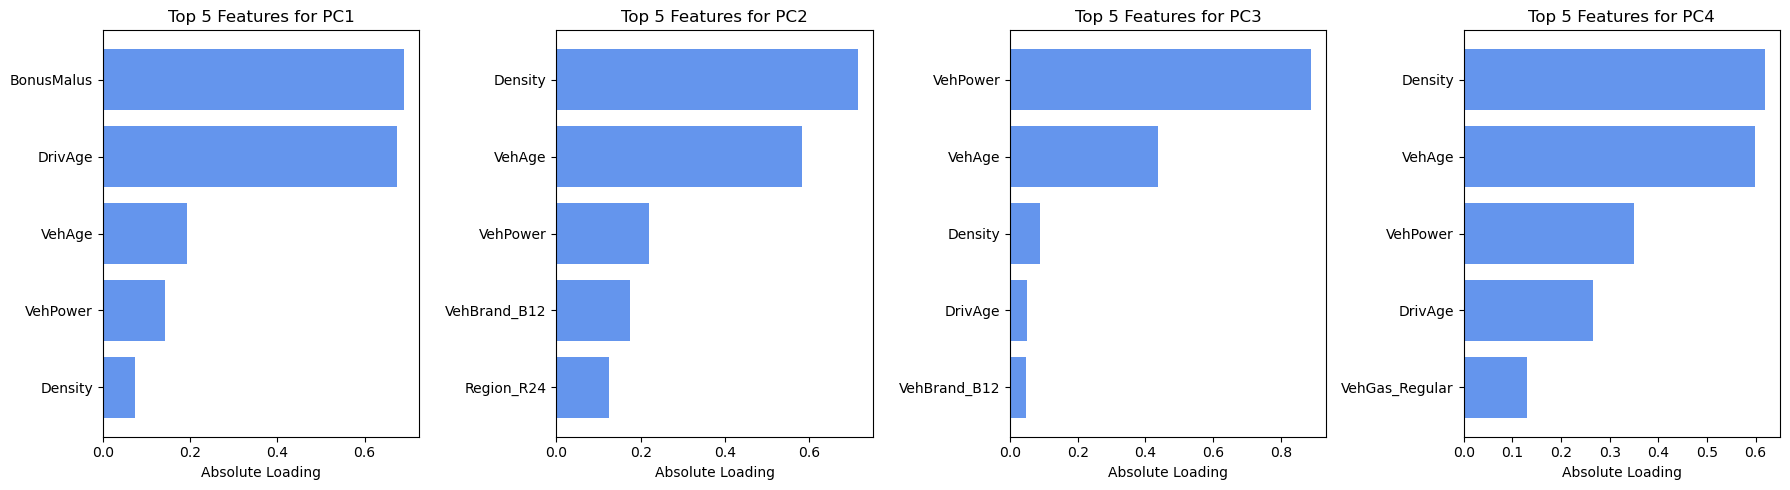

In [229]:
# --- Use the same features PCA was fitted on ---

# --- Compute PCA loadings ---
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=data_encoded.columns
)

# --- Print top 5 features influencing each principal component ---
for i in range(pca.n_components_):
    print(f"\nTop 5 features influencing PC{i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(5))

# --- Visualize only the top 5 features per PC ---
fig, axes = plt.subplots(1, pca.n_components_, figsize=(18, 5))
for i, ax in enumerate(axes):
    # Get top 5 for this PC
    top_features = loadings.iloc[:, i].abs().sort_values(ascending=False).head(5)
    ax.barh(top_features.index[::-1], top_features.values[::-1], color='cornflowerblue')
    ax.set_title(f'Top 5 Features for PC{i+1}')
    ax.set_xlabel('Absolute Loading')

plt.tight_layout()
plt.show()


In [222]:
data_original=pd.read_csv('../data/claims_train.csv')
data_original=clean_data(data_original)
# ✅ Cleaned + fixed version
data_original["Claim_rate"] = (data_original["ClaimNb"] / data_original["Exposure"]).astype(float)

# Add cluster labels from your PCA/KMeans results
data_original["Cluster"] = pca_df["Cluster"]

# Select key columns for summary
cols = ["ClaimNb", "Exposure", "Claim_rate", "DrivAge", "VehAge", "VehPower", "BonusMalus", "Density"]
cols = [c for c in cols if c in data_original.columns]

# Compute simple cluster means + counts
summary = data_original.groupby("Cluster")[cols].mean().round(2)
summary["Count"] = data_original["Cluster"].value_counts().sort_index().values

print("\n=== Cluster Summary (mean values) ===")
print(summary)


=== Cluster Summary (mean values) ===
         ClaimNb  Exposure  Claim_rate  DrivAge  VehAge  VehPower  BonusMalus  \
Cluster                                                                         
0.0         0.05      0.53        0.28    45.53    7.01      6.44       59.84   
1.0         0.05      0.53        0.26    45.54    7.04      6.46       59.72   
2.0         0.05      0.53        0.26    45.49    7.05      6.45       59.78   

         Density   Count  
Cluster                   
0.0      1816.44   12666  
1.0      1793.73  153068  
2.0      1796.04  374689  


In [225]:
for col in ["Claim_rate", "Exposure", "ClaimNb", "DrivAge", "VehAge", "BonusMalus"]:
    print(f"\n{col}:")
    print(data_original.groupby("Cluster")[col].describe()[["mean", "std", "min", "max"]])



Claim_rate:
             mean       std  min    max
Cluster                                
0.0      0.278396  4.698097  0.0  365.0
1.0      0.263714  4.655216  0.0  732.0
2.0      0.260251  4.333211  0.0  366.0

Exposure:
             mean       std       min  max
Cluster                                   
0.0      0.529356  0.362903  0.002732  1.0
1.0      0.526981  0.363440  0.002732  1.0
2.0      0.528006  0.364083  0.002732  1.0

ClaimNb:
             mean       std  min   max
Cluster                               
0.0      0.052582  0.239914  0.0   3.0
1.0      0.053382  0.240029  0.0  11.0
2.0      0.053044  0.238297  0.0  11.0

DrivAge:
              mean        std   min    max
Cluster                                   
0.0      45.529528  14.193390  18.0   96.0
1.0      45.535285  14.142317  18.0   99.0
2.0      45.488160  14.133051  18.0  100.0

VehAge:
             mean       std  min    max
Cluster                                
0.0      7.006948  5.611121  0.0   47.0
1.

In [223]:
print("\nMost common Area per cluster:")
print(data_original.groupby("Cluster")["Area"].agg(lambda x: x.mode()[0]))
print("\nMost common Region per cluster:")
print(data_original.groupby("Cluster")["Region"].agg(lambda x: x.mode()[0]))
print("\nMost common Vehicle brand per cluster:")
print(data_original.groupby("Cluster")["VehBrand"].agg(lambda x: x.mode()[0]))
print("\nMost common Fuel Type per cluster:")
print(data_original.groupby("Cluster")["VehGas"].agg(lambda x: x.mode()[0]))



Most common Area per cluster:
Cluster
0.0    C
1.0    C
2.0    C
Name: Area, dtype: object

Most common Region per cluster:
Cluster
0.0    R24
1.0    R24
2.0    R24
Name: Region, dtype: object

Most common Vehicle brand per cluster:
Cluster
0.0    B12
1.0    B12
2.0    B12
Name: VehBrand, dtype: object

Most common Fuel Type per cluster:
Cluster
0.0    Regular
1.0    Regular
2.0    Regular
Name: VehGas, dtype: object


In [213]:
data_original["Area"].value_counts(normalize=True).head()


Area
C    0.282579
D    0.223490
E    0.202488
A    0.153416
B    0.111450
Name: proportion, dtype: float64

In [214]:
data_original["VehGas"].value_counts(normalize=True).head()

VehGas
Regular    0.510186
Diesel     0.489814
Name: proportion, dtype: float64

In [215]:
data_original["VehBrand"].value_counts(normalize=True).head()

VehBrand
B12    0.245244
B1     0.240058
B2     0.235549
B3     0.078633
B5     0.051338
Name: proportion, dtype: float64

In [216]:
data_original["Region"].value_counts(normalize=True).head()

Region
R24    0.237239
R82    0.124941
R93    0.116862
R11    0.103248
R53    0.062119
Name: proportion, dtype: float64